In [ ]:
# imports
import sys
from pathlib import Path

from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
# for plotting
from tueplots import bundles
from tueplots.constants.color import rgb

plt.rcParams.update(bundles.beamer_moml())
plt.rcParams.update({"figure.dpi": 200})
plt.rcParams.update({'font.sans-serif': ['DejaVu Sans Mono'],'figure.dpi': 200})

# Get my_package directory path from Notebook
parent_dir = str(Path().resolve().parents[1])

# Add to sys.path
sys.path.insert(0, parent_dir)

cmap_wd = LinearSegmentedColormap.from_list("ow", ['w', rgb.tue_dark], N=1024)
cmap_wo = LinearSegmentedColormap.from_list("ow", ['w', rgb.tue_orange], N=1024)
cmap_wb = LinearSegmentedColormap.from_list("ow", ['w', rgb.tue_blue], N=1024)  
cmap_wg = LinearSegmentedColormap.from_list("ow", ['w', rgb.tue_green], N=1024)
cmap_wr = LinearSegmentedColormap.from_list("ow", ['w', rgb.tue_red], N=1024)

In [2]:
import equinox as eqx
import jax
import optax
import numpy as np
from jax import numpy as jnp
from jax import random as jrd
from jaxtyping import Array, Float, Int, PRNGKeyArray, PyTree
from sklearn.datasets import make_moons
from tqdm import tqdm

Some global constants:

In [3]:
KEY = jrd.key(0)
LAYER_SIZES = [3, 128, 128, 256, 2]  # our model maps (x1,x2,t) -> (score_1,score_2)
BATCH_SIZE = 1000
LEARNING_RATE = 9e-3
NUM_EPOCHS = 10
N = 100_000
LOG_FREQUENCY = 1

In [4]:
class DiffusionProcess:
    def __init__(self, alpha: callable):
        self.alpha = alpha
        self.sigma = lambda t: jnp.sqrt(1 - self.alpha(t))

    def forward(
        self, key: PRNGKeyArray, x0: Float[Array, "B D"], t: Float[Array, "B"]
    ) -> tuple[Float[Array, "B D"], Float[Array, "B D"]]:
        eps = jrd.normal(key, x0.shape)
        return jnp.sqrt(self.alpha(t)) * x0 + self.sigma(t) * eps, eps

    def backward(
        self,
        x1: Float[Array, "B D"],
        key: jrd.PRNGKey,
        score: callable,
        numsteps: int,
        save_intermediates: bool = False,
    ) -> Float[Array, "B D"]:
        if save_intermediates:
            intermediates = []
            intermediates.append(x1)

        steps = jnp.linspace(1 - 1e-3, 0 + 1e-3, numsteps)
        xt = x1
        keys = jrd.split(key, numsteps)
        tau_t = 0.0 / numsteps
        for t, tm, key in zip(steps[:-1], steps[1:], keys):
            t = jnp.asarray(t)
            tm = jnp.asarray(tm)
            assert tm < t

            predicted_noise = jax.vmap(score)(xt, jnp.repeat(t, xt.shape[0])[:, None])

            x0_hat = (xt - self.sigma(t) * predicted_noise) / self.alpha(t)
            # xt = self.alpha(tm) * x0_hat + jnp.sqrt(self.sigma(t)**2 - tau_t**2) * predicted_noise + tau_t * jrd.normal(key, xt.shape)
            xt = self.alpha(tm) * x0_hat + self.sigma(tm) * predicted_noise

            if save_intermediates:
                intermediates.append(xt)

        if save_intermediates:
            intermediates = jnp.stack(intermediates, axis=0)
            return xt, intermediates, steps
        else:
            return xt

In [5]:
def alpha(t):
    return jnp.cos(t * jnp.pi / 2.1)


MyProcess = DiffusionProcess(alpha=alpha)

Now we can generate from the forward process

In [6]:
from ipywidgets import interact, widgets

X0 = jnp.array(make_moons(n_samples=1000, noise=0.05)[0])


@interact(t=widgets.FloatSlider(min=0, max=1 - 1e-3, step=0.01, value=0))
def show_diffusion(t):

    xt = MyProcess.forward(jrd.PRNGKey(0), X0, t)

    fig, axs = plt.subplots(1, 2)
    ax = axs[0]
    ax.scatter(X0[:, 0], X0[:, 1], label="Original", alpha=0.5, s=2, color=rgb.tue_gray)
    ax.scatter(xt[0][:, 0], xt[0][:, 1], label="Noisy", alpha=0.5, s=2)
    ax.legend(loc="upper right")
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.set_aspect("equal")

    tplot = jnp.linspace(0, 1, 200)
    axs[1].plot(tplot, MyProcess.alpha(tplot), label=r"$\alpha(t)$")
    axs[1].plot(tplot, MyProcess.sigma(tplot), label=r"$\sigma(t)$")
    axs[1].axvline(t, color=rgb.tue_gray, linestyle="-")
    axs[1].legend()

    plt.show()

interactive(children=(FloatSlider(value=0.0, description='t', max=0.999, step=0.01), Output()), _dom_classes=(…

## Training a DDIM (denoising diffusion implicit models) from data

We define a model class (here, a simple multi-layer perceptron)

In [7]:
class MLP(eqx.Module):
    layers: list[eqx.nn.Linear]

    def __init__(self, key: PRNGKeyArray, layer_sizes: list[int]) -> None:
        keys = jax.random.split(key, len(layer_sizes) - 1)
        self.layers = [
            eqx.nn.Linear(layer_sizes[i], layer_sizes[i + 1], key=keys[i])
            for i in range(len(layer_sizes) - 1)
        ]

    def __call__(self, x: Float[Array, "B D"], t) -> Float[Array, "B 1"]:
        h = jnp.concat([x, t], axis=-1)
        for layer in self.layers[:-1]:
            h = jax.nn.silu(layer(h))

        return self.layers[-1](h)


KEY, model_key = jrd.split(KEY)
model = MLP(model_key, layer_sizes=LAYER_SIZES)

and build a dataset / loader:

In [8]:
# Data Loader:
import torch.utils.data as data


# This collate function is taken from the JAX tutorial with PyTorch Data Loading
# https://jax.readthedocs.io/en/latest/notebooks/Neural_Network_and_Data_Loading.html
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple, list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

In [9]:
class MyDataset(data.Dataset):
    def __init__(self, N: int = 200, key: PRNGKeyArray = None) -> None:
        self.key = key
        self.N = N
        self.data = make_moons(n_samples=N, noise=0.05)[0]

    def __len__(self) -> int:
        return self.N

    def __getitem__(self, idx) -> Float[Array, "D"]:
        self.key, _ = jrd.split(self.key)
        return self.data[idx]


# instantiate the dataset
KEY, trainkey = jrd.split(KEY, 2)
train_dataset = MyDataset(key=trainkey, N=N)
train_loader = data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=numpy_collate
)

# test the data loader:
data_input = next(iter(train_loader))
data_input.shape

(1000, 2)

Define a loss function:

In [10]:
@eqx.filter_jit
def loss_fn(
    model: MLP, key: PRNGKeyArray, x: Float[Array, "B 2"], process: DiffusionProcess
) -> Float[Array, ""]:
    key, tkey, processkey = jrd.split(key, 3)
    t = jrd.uniform(tkey, (x.shape[0], 1), minval=0.0, maxval=1.0)
    xt, eps = process.forward(processkey, x, t)
    pred_eps = jax.vmap(model)(xt, t)

    return optax.losses.l2_loss(pred_eps, eps).mean()
    # return ((pred_eps - eps) ** 2).mean()


batch_loss, batch_grads = eqx.filter_value_and_grad(loss_fn)(
    model, KEY, data_input, MyProcess
)

print(f"{batch_loss = }")

batch_loss = Array(0.51220244, dtype=float32)


In [11]:
optimizer = optax.adamw(learning_rate=LEARNING_RATE, weight_decay=1e-3)

In [12]:
def train(
    key: PRNGKeyArray,
    model: MLP,
    process: DiffusionProcess,
    train_loader: data.DataLoader,
    optimizer: optax.GradientTransformation,
    num_epochs: int,
) -> MLP:
    opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

    @eqx.filter_jit
    def make_step(
        stepkey: PRNGKeyArray,
        model: MLP,
        opt_state: PyTree,
        batch: Float[Array, "B 2"],
    ) -> tuple[MLP, PyTree, Float[Array, ""]]:
        loss_value, grads = eqx.filter_value_and_grad(loss_fn)(
            model, stepkey, batch, process
        )
        updates, opt_state = optimizer.update(
            grads, opt_state, eqx.filter(model, eqx.is_array)
        )
        model = eqx.apply_updates(model, updates)

        return model, opt_state, loss_value

    loss_log = []
    pbar = tqdm(range(2000), desc="Training Progress", unit="epoch")
    for epoch in pbar:
        # for batch in train_loader:
        batch = jnp.array(make_moons(1024, noise=0.05)[0])
        key, subkey = jrd.split(key)
        model, opt_state, train_loss = make_step(key, model, opt_state, batch)
        loss_log.append(train_loss.item())
        pbar.set_postfix({"loss": train_loss.item()})

    return model, loss_log

and run the training loop:

Training Progress: 100%|██████████| 2000/2000 [00:07<00:00, 257.62epoch/s, loss=0.228]
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Ro

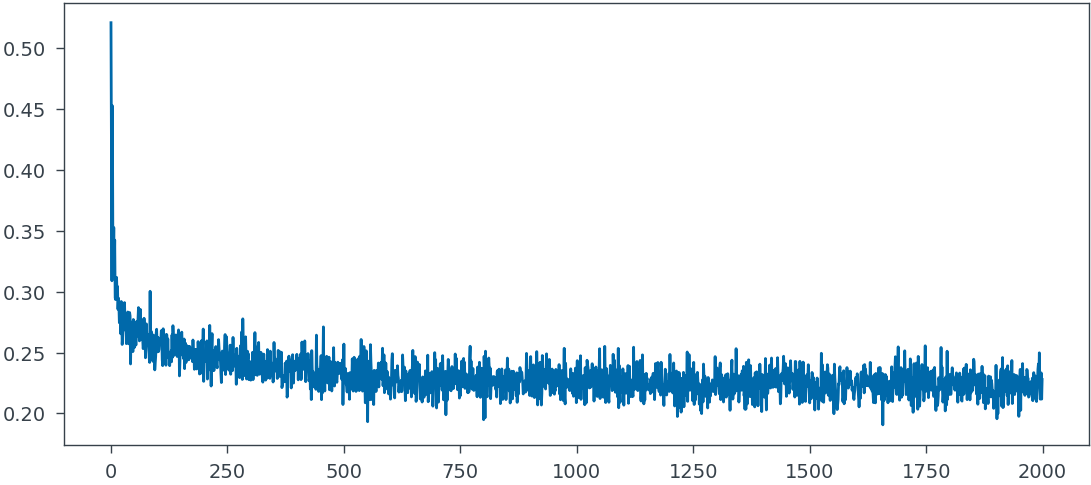

In [13]:
model, loss_log = train(KEY, model, MyProcess, train_loader, optimizer, NUM_EPOCHS)

fig, ax = plt.subplots()
ax.plot(loss_log, color=rgb.tue_blue);

Plot the results:

First, the learned vector field:

In [14]:
import numpy as np
from ipywidgets import interact, widgets

X0 = jnp.array(make_moons(n_samples=100, noise=0.05)[0])
X2, X1 = jnp.mgrid[-3:3:100j, -3:3:100j]


@interact(t=widgets.FloatSlider(min=0.1, max=1, step=0.1, value=1.0))
def plot_trajectory(t):
    X_grid = jnp.stack([X1.flatten(), X2.flatten()], axis=1)

    # plot the score:
    Y_grid = -jax.vmap(model)(
        X_grid, np.ones((X_grid.shape[0], 1)) * t
    ).flatten() / MyProcess.sigma(t)
    Y_grid = Y_grid.reshape(X1.shape[0], X1.shape[1], 2)
    speed = np.sqrt((Y_grid**2).sum(axis=2))
    print(f"{Y_grid.shape = }")

    fig, ax = plt.subplots()
    ax.streamplot(
        np.array(X1),
        np.array(X2),
        np.array(Y_grid[:, :, 0]),
        np.array(Y_grid[:, :, 1]),
        color=speed,
        linewidth=0.5,
    )
    ax.scatter(X0[:, 0], X0[:, 1], s=10, color=rgb.tue_gray, alpha=0.5)

interactive(children=(FloatSlider(value=1.0, description='t', max=1.0, min=0.1), Output()), _dom_classes=('wid…

And run the denoising process:

In [15]:
n_particles = 1000
generate_key, init_key, KEY = jrd.split(KEY, 3)
inits = jrd.normal(init_key, shape=(n_particles, 2))
generations, intermediates, tsteps = MyProcess.backward(
    inits, key=generate_key, score=model, numsteps=100, save_intermediates=True
)
intermediates[4,:,:]

Array([[-1.3666805 ,  0.8678317 ],
       [ 1.5573918 ,  1.8415098 ],
       [-0.8260702 , -0.7565585 ],
       ...,
       [ 0.82421005,  0.5398605 ],
       [-1.5456352 ,  0.930688  ],
       [ 0.3175727 ,  0.939949  ]], dtype=float32)

In [16]:
@interact(i=widgets.IntSlider(min=0, max=len(tsteps), step=1, value=0))
def plot_gen_trajectory(i):
    t = tsteps[i]
    X_grid = jnp.stack([X1.flatten(), X2.flatten()], axis=1)

    # plot the score:
    Y_grid = -jax.vmap(model)(
        X_grid, np.ones((X_grid.shape[0], 1)) * t
    ).flatten() / MyProcess.sigma(t)
    Y_grid = Y_grid.reshape(X1.shape[0], X1.shape[1], 2)
    speed = np.sqrt((Y_grid**2).sum(axis=2))
    print(f"{Y_grid.shape = }")

    fig, ax = plt.subplots()
    ax.streamplot(
        np.array(X1),
        np.array(X2),
        np.array(Y_grid[:, :, 0]),
        np.array(Y_grid[:, :, 1]),
        color=speed,
        linewidth=0.5,
    )
    ax.scatter(X0[:, 0], X0[:, 1], s=10, color=rgb.tue_gray, alpha=0.5)
    ax.scatter(intermediates[i, :, 0], intermediates[i, :, 1], s=3)
    ax.scatter(generations[:, 0], generations[:, 1], s = 3)
    ax.set_ylim((-3, 3))
    ax.set_xlim((-3, 3))
    ax.set_title(f"[Step {i}] t = {t:.3f}")
    ax.set_aspect("equal")
    return fig


interact(
    plot_gen_trajectory,
    i=widgets.IntSlider(min=0, max=len(tsteps), step=1, value=0),
)

interactive(children=(IntSlider(value=0, description='i'), Output()), _dom_classes=('widget-interact',))

interactive(children=(IntSlider(value=0, description='i'), Output()), _dom_classes=('widget-interact',))

<function __main__.plot_gen_trajectory(i)>